In scikit-learn a random split into training and test sets can be quickly computed with the train_test_split helper function. Let’s load the iris data set to fit a linear support vector machine on it

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
X, y = datasets.load_iris(return_X_y=True)
X.shape, y.shape

((150, 4), (150,))

In [2]:
#We can now quickly sample a training set while holding out 40% of the data for testing (evaluating) our classifier:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=0)
X_train.shape, y_train.shape
X_test.shape, y_test.shape
clf = svm.SVC(kernel='linear',C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9666666666666667

When evaluating different settings (“hyperparameters”) for estimators, such as the C setting that must be manually set for an SVM, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

A model is trained using  of the folds as training data;

the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.

<img src="grid_search_cross_validation.png"  style="width: 450px">

# Computing Cross Validation Metrics

The simplest way to use cross-validation is to call the cross_val_score helper function on the estimator and the dataset.

The following example demonstrates how to estimate the accuracy of a linear kernel support vector machine on the iris dataset by splitting the data, fitting a model and computing the score 5 consecutive times (with different splits each time)

In [3]:
from sklearn.model_selection import cross_val_score
clf=svm.SVC(kernel='linear',C=1,random_state=1)
scores=cross_val_score(clf,X,y,cv=5)
scores

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

In [4]:
# The mean and standard deviation is given by:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.98 accuracy with a standard deviation of 0.02


In [5]:
#By default, the score computed at each CV iteration is the score method of the estimator. It is possible to change 
#this by using the scoring parameter:
from sklearn import metrics
scores=cross_val_score(clf,X,y,scoring='f1_macro')
scores

array([0.96658312, 1.        , 0.96658312, 0.96658312, 1.        ])

When the cv argument is an integer, cross_val_score uses the KFold or StratifiedKFold strategies by default, the latter being used if the estimator derives from ClassifierMixin.

In [6]:
# It is also possible to use other cross validation strategies by passing a cross validation iterator instead, for instance
from sklearn.model_selection import ShuffleSplit
n_samples = X.shape[0]
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
cross_val_score(clf, X, y, cv=cv)

array([0.97777778, 0.97777778, 1.        , 0.95555556, 1.        ,
       0.97777778, 0.97777778, 1.        , 0.97777778, 0.97777778])

In [7]:
#It is also possible to use other cross validation strategies by passing a cross validation iterator instead
# Custom_cross_validation 
def custom_cv_2folds(X):
        n = X.shape[0]
        i = 1
        while i <= 2:
            idx = np.arange(n * (i - 1) / 2, n * i / 2, dtype=int)
            yield idx, idx
            i += 1

custom_cv = custom_cv_2folds(X)
cross_val_score(clf, X, y, cv=custom_cv)

array([1.        , 0.97333333])

# Data transformation with held out data

Just as it is important to test a predictor on data held-out from training, preprocessing (such as standardization, feature selection, etc.) and similar data transformations similarly should be learnt from a training set and applied to held-out data for prediction:

In [8]:
from sklearn import preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
clf = svm.SVC(C=1).fit(X_train_transformed, y_train)
X_test_transformed = scaler.transform(X_test)
clf.score(X_test_transformed, y_test)

0.9333333333333333

In [9]:
#A Pipeline makes it easier to compose estimators, providing this behavior under cross-validation:
from sklearn.pipeline import make_pipeline
clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=1))
cross_val_score(clf, X, y, cv=cv)

array([0.97777778, 0.93333333, 0.95555556, 0.93333333, 0.97777778,
       0.93333333, 1.        , 1.        , 0.95555556, 1.        ])

# cross_validate function and multiple metric evaluation

The cross_validate function differs from cross_val_score in two ways:

1. It allows specifying multiple metrics for evaluation.

2. It returns a dict containing fit-times, score-times (and optionally training scores as well as fitted estimators) in addition to the test score.

3. For single metric evaluation, where the scoring parameter is a string, callable or None, the keys will be - ['test_score','fit_time', 'score_time']

4. And for multiple metric evaluation, the return value is a dict with the following keys - 

['test_<scorer1_name>', 'test_<scorer2_name>', 'test_<scorer...>', 'fit_time', 'score_time']

return_train_score is set to False by default to save computation time. To evaluate the scores on the training set as well you need to be set to True.

5. You may also retain the estimator fitted on each training set by setting return_estimator=True.The multiple metrics can be specified either as a list, tuple or set of predefined scorer names

In [10]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['precision_macro', 'recall_macro']
clf = svm.SVC(kernel='linear', C=1, random_state=0)
scores = cross_validate(clf, X, y, scoring=scoring)
sorted(scores.keys())
['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']
print('The test_recall_macro is:',scores['test_recall_macro'])
print('The score_time is:',scores['score_time'])
print('The fit_time is:',scores['fit_time'])

The test_recall_macro is: [0.96666667 1.         0.96666667 0.96666667 1.        ]
The score_time is: [0. 0. 0. 0. 0.]
The fit_time is: [0.01560855 0.         0.         0.01562428 0.        ]


In [11]:
#Or as a dict mapping scorer name to a predefined or custom scoring function:
from sklearn.metrics import make_scorer
scoring = {'prec_macro': 'precision_macro',
           'rec_macro': make_scorer(recall_score, average='macro')}
scores = cross_validate(clf, X, y, scoring=scoring,
                        cv=5, return_train_score=True)
sorted(scores.keys())

print('The train_recall scores is:',scores['train_rec_macro'])
print('The fit_time is:',scores['fit_time'])
print('The score_time is:',scores['score_time'])

The train_recall scores is: [0.975      0.975      0.99166667 0.98333333 0.98333333]
The fit_time is: [0. 0. 0. 0. 0.]
The score_time is: [0.         0.01556897 0.         0.01561117 0.        ]


In [12]:
#Here is an example of cross_validate using a single metric:
scores = cross_validate(clf, X, y,
                        scoring='precision_macro', cv=5,
                        return_estimator=True)
sorted(scores.keys())

['estimator', 'fit_time', 'score_time', 'test_score']

# Obtaining predictions by cross-validation

The function cross_val_predict has a similar interface to cross_val_score, but returns, for each element in the input, the prediction that was obtained for that element when it was in the test set. Only cross-validation strategies that assign all elements to a test set exactly once can be used (otherwise, an exception is raised).

Warning:-

1. The result of cross_val_predict may be different from those obtained using cross_val_score as the elements are grouped in different ways. 

2. The function cross_val_score takes an average over cross-validation folds, whereas cross_val_predict simply returns the labels (or probabilities) from several distinct models undistinguished. Thus, cross_val_predict is not an appropriate measure of generalisation error

The function cross_val_predict is appropriate for:

1. Visualization of predictions obtained from different models.

2. Model blending: When predictions of one supervised estimator are used to train another estimator in ensemble methods.

# K-fold
KFold divides all the samples in k groups of samples, called folds (if k=n, this is equivalent to the Leave One Out strategy), of equal sizes (if possible). The prediction function is learned using k-1 folds, and the fold left out is used for test.

In [13]:
#Example of 2-fold cross-validation on a dataset with 4 samples
from sklearn.model_selection import KFold
X=["a","b","c","d"]
kf=KFold(n_splits=2)
for train,test in kf.split(X):
    print("%s %s" % (train,test))

[2 3] [0 1]
[0 1] [2 3]


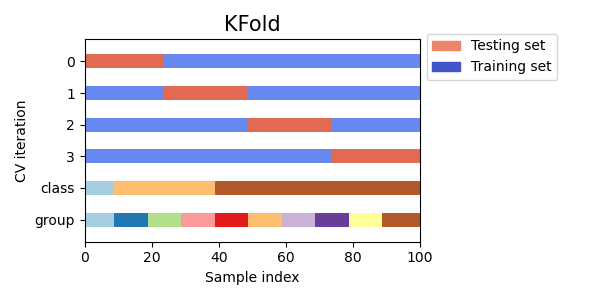

Each fold is constituted by two arrays: the first one is related to the training set, and the second one to the test set. Thus, one can create the training/test sets using numpy indexing:

In [14]:
X = np.array([[0., 0.], [1., 1.], [-1., -1.], [2., 2.]])
y = np.array([0, 1, 0, 1])
X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

In [15]:
import numpy as np
from sklearn.model_selection import KFold
X_KFold=np.array([[1,2],[3,4],[1,2],[3,4]])
kf=KFold(n_splits=2)
for train,test in kf.split(X_KFold):
    print(" %s %s" % (train,test))

 [2 3] [0 1]
 [0 1] [2 3]


# Why use repeated cross-validation ?

First of all repeated cross-validation is just repeating cross-validation multiple times where in each repetition, the folds are split in a different way. After each repetition of the cross-validation, the model assessment metric is computed (e.g. accuracy or RMSE). The scores from all repetitions are finally averaged (you can also take the median), to get a final model assessment score. This gives a more “robust” model assessment score than performing cross-validation only once, which is what I aim to demonstrate. Then I will perform hyper-parameter tuning using cross-validation.

# Repeated K-Fold

RepeatedKFold repeats K-Fold n times. It can be used when one requires to run KFold n times, producing different splits in each repetition.

In [16]:
#Example of 2-fold K-Fold repeated 2 times
import numpy as np
from sklearn.model_selection import RepeatedKFold
X=np.array([[1,2],[3,4],[1,2],[3,4]])
rkf=RepeatedKFold(n_splits=2,n_repeats=2,random_state=1)
for train,test in rkf.split(X):
    print(" %s %s" % (train,test))

 [0 1] [2 3]
 [2 3] [0 1]
 [1 3] [0 2]
 [0 2] [1 3]


# Leave One Out (LOO)

LeaveOneOut (or LOO) is a simple cross-validation. Each learning set is created by taking all the samples except one, the test set being the sample left out. Thus for n samples, we have  n different training sets and n different tests set. This cross-validation procedure does not waste much data as only one sample is removed from the training set:

In [28]:
from sklearn.model_selection import LeaveOneOut
X=np.array([1,2,3,4])
loo=LeaveOneOut()
for train,test in loo.split(X):
    print("%s %s" % (train,test))

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


Potential users of LOO for model selection should weigh a few known caveats. When compared with k-fold cross validation, one builds  n models from  n samples instead of k models, where n>k Moreover, each is trained on (n-1) samples rather than (k-1)k In both ways, assuming  k is not too large and k<n, LOO is more computationally expensive than k-fold cross validation.

In terms of accuracy, LOO often results in high variance as an estimator for the test error. Intuitively,n-1 since  of the n samples are used to build each model, models constructed from folds are virtually identical to each other and to the model built from the entire training set.

However, if the learning curve is steep for the training size in question, then 5- or 10- fold cross validation can overestimate the generalization error.

As a general rule, most authors, and empirical evidence, suggest that 5- or 10- fold cross validation should be preferred to LOO.

# Leave P Out (LPO)

LeavePOut is very similar to LeaveOneOut as it creates all the possible training/test sets by removing p samples from the complete set. For n samples, this produces (n/p pairs) train-test pairs. Unlike LeaveOneOut and KFold, the test sets will overlap for p>1

In [33]:
from sklearn.model_selection import LeavePOut

X=np.ones(4)
lpo=LeavePOut(p=2)
for train,test in lpo.split(X):
    print("%s %s" %(train,test))

[2 3] [0 1]
[1 3] [0 2]
[1 2] [0 3]
[0 3] [1 2]
[0 2] [1 3]
[0 1] [2 3]


# Random permutations cross-validation a.k.a. Shuffle & Split

The ShuffleSplit iterator will generate a user defined number of independent train / test dataset splits. Samples are first shuffled and then split into a pair of train and test sets.

It is possible to control the randomness for reproducibility of the results by explicitly seeding the random_state pseudo random number generator.

In [56]:
from sklearn.model_selection import ShuffleSplit
X = np.arange(10)
ss = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)
for train_index, test_index in ss.split(X):
    print("%s %s" % (train_index,test_index))

[4 9 1 6 7 3 0 5] [2 8]
[1 2 9 8 0 6 7 4] [3 5]
[8 4 5 1 0 6 9 7] [2 3]
[9 2 7 5 8 0 3 4] [6 1]
[7 4 1 0 6 8 9 3] [5 2]


ShuffleSplit is thus a good alternative to KFold cross validation that allows a finer control on the number of iterations and the proportion of samples on each side of the train / test split.It  is not affected by classes or groups.

# Cross-validation iterators with stratification based on class labels

Some classification problems can exhibit a large imbalance in the distribution of the target classes: for instance there could be several times more negative samples than positive samples. In such cases it is recommended to use stratified sampling as implemented in StratifiedKFold and StratifiedShuffleSplit to ensure that relative class frequencies is approximately preserved in each train and validation fold.

# Stratified k-fold

StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.

Here is an example of stratified 3-fold cross-validation on a dataset with 50 samples from two unbalanced classes. We show the number of samples in each class and compare with KFold.

In [76]:
# This is the implementation of StratifiedKFold
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
X, y = np.ones((50, 1)), np.hstack(([0] * 45, [1] * 5))
skf = StratifiedKFold(n_splits=3,shuffle=False)
for train, test in skf.split(X, y):
    print('train -  {}   |   test -  {}'.format(
        np.bincount(y[train]), np.bincount(y[test])))

train -  [30  3]   |   test -  [15  2]
train -  [30  3]   |   test -  [15  2]
train -  [30  4]   |   test -  [15  1]


We can see that StratifiedKFold preserves the class ratios (approximately 1 / 10) in both train and test dataset.

In [70]:
kf = KFold(n_splits=3)
for train, test in kf.split(X, y):
    print('train -  {}   |   test -  {}'.format(
        np.bincount(y[train]), np.bincount(y[test])))

train -  [28  5]   |   test -  [17]
train -  [28  5]   |   test -  [17]
train -  [34]   |   test -  [11  5]


In [77]:
repeated_kf = RepeatedKFold(n_splits=3)
for train, test in repeated_kf.split(X, y):
    print('train -  {}   |   test -  {}'.format(
        np.bincount(y[train]), np.bincount(y[test])))

train -  [29  4]   |   test -  [16  1]
train -  [30  3]   |   test -  [15  2]
train -  [31  3]   |   test -  [14  2]
train -  [28  5]   |   test -  [17]
train -  [32  1]   |   test -  [13  4]
train -  [30  4]   |   test -  [15  1]
train -  [29  4]   |   test -  [16  1]
train -  [31  2]   |   test -  [14  3]
train -  [30  4]   |   test -  [15  1]
train -  [32  1]   |   test -  [13  4]
train -  [29  4]   |   test -  [16  1]
train -  [29  5]   |   test -  [16]
train -  [28  5]   |   test -  [17]
train -  [29  4]   |   test -  [16  1]
train -  [33  1]   |   test -  [12  4]
train -  [30  3]   |   test -  [15  2]
train -  [28  5]   |   test -  [17]
train -  [32  2]   |   test -  [13  3]
train -  [30  3]   |   test -  [15  2]
train -  [29  4]   |   test -  [16  1]
train -  [31  3]   |   test -  [14  2]
train -  [29  4]   |   test -  [16  1]
train -  [28  5]   |   test -  [17]
train -  [33  1]   |   test -  [12  4]
train -  [31  2]   |   test -  [14  3]
train -  [29  4]   |   test -  [16  1]
t

In [85]:
from sklearn.model_selection import RepeatedStratifiedKFold
repeated_star_kf = RepeatedStratifiedKFold(n_splits=3,n_repeats=5)
for train, test in repeated_star_kf.split(X, y):
    print('train -  {}   |   test -  {}'.format(
        np.bincount(y[train]), np.bincount(y[test])))

train -  [30  3]   |   test -  [15  2]
train -  [30  3]   |   test -  [15  2]
train -  [30  4]   |   test -  [15  1]
train -  [30  3]   |   test -  [15  2]
train -  [30  3]   |   test -  [15  2]
train -  [30  4]   |   test -  [15  1]
train -  [30  3]   |   test -  [15  2]
train -  [30  3]   |   test -  [15  2]
train -  [30  4]   |   test -  [15  1]
train -  [30  3]   |   test -  [15  2]
train -  [30  3]   |   test -  [15  2]
train -  [30  4]   |   test -  [15  1]
train -  [30  3]   |   test -  [15  2]
train -  [30  3]   |   test -  [15  2]
train -  [30  4]   |   test -  [15  1]


RepeatedStratifiedKFold can be used to repeat Stratified K-Fold n times with different randomization in each repetition.

# StratifiedShuffleSplit
StratifiedShuffleSplit is a variation of ShuffleSplit, which returns stratified splits, i.e which creates splits by preserving the same percentage for each target class as in the complete set.

In [97]:
# Implementation Of StratifiedShuffleSplit
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 0, 1, 1, 1])
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.4, random_state=0)
sss.get_n_splits(X, y)

print(sss)

for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.4,
            train_size=None)
TRAIN: [5 2 3] TEST: [4 1 0]
TRAIN: [5 1 4] TEST: [0 2 3]
TRAIN: [5 0 2] TEST: [4 3 1]
TRAIN: [4 1 0] TEST: [2 3 5]
TRAIN: [0 5 1] TEST: [3 4 2]


In [98]:
# Comparing StratifiedShuffleSplit and ShuffleSplit
import numpy as np
from sklearn.model_selection import ShuffleSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 0, 1, 1, 1])
sss_1 = ShuffleSplit(n_splits=5, test_size=0.4, random_state=0)
sss_1.get_n_splits(X, y)

print(sss_1)

for train_index, test_index in sss_1.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

ShuffleSplit(n_splits=5, random_state=0, test_size=0.4, train_size=None)
TRAIN: [3 0 4] TEST: [5 2 1]
TRAIN: [0 2 5] TEST: [1 3 4]
TRAIN: [2 4 0] TEST: [3 5 1]
TRAIN: [4 1 0] TEST: [5 2 3]
TRAIN: [5 1 0] TEST: [2 4 3]


# Cross-validation iterators for grouped data.

The assumption is broken if the underlying generative process yield groups of dependent samples.

Such a grouping of data is domain specific. An example would be when there is medical data collected from multiple patients, with multiple samples taken from each patient. And such data is likely to be dependent on the individual group. In our example, the patient id for each sample will be its group identifier.

In this case we would like to know if a model trained on a particular set of groups generalizes well to the unseen groups. To measure this, we need to ensure that all the samples in the validation fold come from groups that are not represented at all in the paired training fold.

The following cross-validation splitters can be used to do that. The grouping identifier for the samples is specified via the groups parameter.

# Group k-fold

GroupKFold is a variation of k-fold which ensures that the same group is not represented in both testing and training sets. For example if the data is obtained from different subjects with several samples per-subject and if the model is flexible enough to learn from highly person specific features it could fail to generalize to new subjects. GroupKFold makes it possible to detect this kind of overfitting situations.

In [99]:
from sklearn.model_selection import GroupKFold

X = [0.1, 0.2, 2.2, 2.4, 2.3, 4.55, 5.8, 8.8, 9, 10]
y = ["a", "b", "b", "b", "c", "c", "c", "d", "d", "d"]
groups = [1, 1, 1, 2, 2, 2, 3, 3, 3, 3]

gkf = GroupKFold(n_splits=3)
for train, test in gkf.split(X, y, groups=groups):
    print("%s %s" % (train, test))

[0 1 2 3 4 5] [6 7 8 9]
[0 1 2 6 7 8 9] [3 4 5]
[3 4 5 6 7 8 9] [0 1 2]


Each subject is in a different testing fold, and the same subject is never in both testing and training. Notice that the folds do not have exactly the same size due to the imbalance in the data.

# Leave One Group Out
    
1. LeaveOneGroupOut is a cross-validation scheme which holds out the samples according to a third-party provided array of integer groups. This group information can be used to encode arbitrary domain specific pre-defined cross-validation folds.


2. Each training set is thus constituted by all the samples except the ones related to a specific group.

For example, in the cases of multiple experiments, LeaveOneGroupOut can be used to create a cross-validation based on the different experiments: we create a training set using the samples of all the experiments except one:

In [100]:
from sklearn.model_selection import LeaveOneGroupOut

X = [1, 5, 10, 50, 60, 70, 80]
y = [0, 1, 1, 2, 2, 2, 2]
groups = [1, 1, 2, 2, 3, 3, 3]
logo = LeaveOneGroupOut()
for train, test in logo.split(X, y, groups=groups):
    print("%s %s" % (train, test))

[2 3 4 5 6] [0 1]
[0 1 4 5 6] [2 3]
[0 1 2 3] [4 5 6]


Another common application is to use time information: for instance the groups could be the year of collection of the samples and thus allow for cross-validation against time-based splits.

# Leave P Groups Out

LeavePGroupsOut is similar as LeaveOneGroupOut, but removes samples related to  P groups for each training/test set.

In [108]:
# This is the implementation Of Leave P Group Out
from sklearn.model_selection import LeavePGroupsOut
X=np.arange(10)
y=[1,1,1,2,2,2,2,3,3,3]
groups=[1,1,1,2,2,2,2,3,3,4]
lgo=LeavePGroupsOut(n_groups=2)
for train,test in lgo.split(X,y,groups=groups):
    print("%s %s" %(train,test))

[7 8 9] [0 1 2 3 4 5 6]
[3 4 5 6 9] [0 1 2 7 8]
[3 4 5 6 7 8] [0 1 2 9]
[0 1 2 9] [3 4 5 6 7 8]
[0 1 2 7 8] [3 4 5 6 9]
[0 1 2 3 4 5 6] [7 8 9]


# Group Shuffle Split

The GroupShuffleSplit iterator behaves as a combination of ShuffleSplit and LeavePGroupsOut, and generates a sequence of randomized partitions in which a subset of groups are held out for each split.

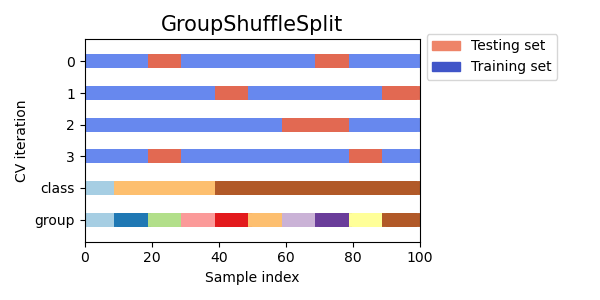

In [116]:
from sklearn.model_selection import GroupShuffleSplit

X = [0.1, 0.2, 2.2, 2.4, 2.3, 4.55, 5.8, 0.001]
y = ["a", "b", "b", "b", "c", "c", "c", "a"]
groups = [1, 1, 2, 2, 3, 3, 4, 4]
gss = GroupShuffleSplit(n_splits=2, test_size=0.5, random_state=42)
for train, test in gss.split(X, y, groups=groups):
    print("%s %s" % (train, test))

[0 1 4 5] [2 3 6 7]
[0 1 4 5] [2 3 6 7]


This class is useful when the behavior of LeavePGroupsOut is desired, but the number of groups is large enough that generating all possible partitions with P groups withheld would be prohibitively expensive. In such a scenario, GroupShuffleSplit provides a random sample (with replacement) of the train / test splits generated by LeavePGroupsOut.

# Predefined Fold-Splits / Validation-Sets
    
For some datasets, a pre-defined split of the data into training- and validation fold or into several cross-validation folds already exists. Using PredefinedSplit it is possible to use these folds e.g. when searching for hyperparameters.

For example, when using a validation set, set the test_fold to 0 for all samples that are part of the validation set, and to -1 for all other samples.

In [127]:
from sklearn.model_selection import PredefinedSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 1, 1])
test_fold = [0, 0, 1, -1]
ps = PredefinedSplit(test_fold)
ps.get_n_splits()

print(ps)

for train_index, test_index in ps.split():
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

PredefinedSplit(test_fold=array([ 0,  0,  1, -1]))
TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1 3] TEST: [2]


# Using cross-validation iterators to split train and test

The above group cross-validation functions may also be useful for spitting a dataset into training and testing subsets. Note that the convenience function train_test_split is a wrapper around ShuffleSplit and thus only allows for stratified splitting (using the class labels) and cannot account for groups.

To perform the train and test split, use the indices for the train and test subsets yielded by the generator output by the split() method of the cross-validation splitter.

In [128]:
from sklearn.model_selection import GroupShuffleSplit

X = np.array([0.1, 0.2, 2.2, 2.4, 2.3, 4.55, 5.8, 0.001])
y = np.array(["a", "b", "b", "b", "c", "c", "c", "a"])
groups = np.array([1, 1, 2, 2, 3, 3, 4, 4])
train_indx, test_indx = next(
    GroupShuffleSplit(random_state=7).split(X, y, groups)
)
X_train, X_test, y_train, y_test = \
    X[train_indx], X[test_indx], y[train_indx], y[test_indx]
X_train.shape, X_test.shape

np.unique(groups[train_indx]), np.unique(groups[test_indx])

(array([1, 2, 4]), array([3]))

# Cross validation of time series data

Time series data is characterised by the correlation between observations that are near in time (autocorrelation). However, classical cross-validation techniques such as KFold and ShuffleSplit assume the samples are independent and identically distributed, and would result in unreasonable correlation between training and testing instances (yielding poor estimates of generalisation error) on time series data. Therefore, it is very important to evaluate our model for time series data on the “future” observations least like those that are used to train the model. To achieve this, one solution is provided by TimeSeriesSplit.

# Time Series Split

TimeSeriesSplit is a variation of k-fold which returns first  folds as train set and the  (k+1)th fold as test set. Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them. Also, it adds all surplus data to the first training partition, which is always used to train the model.

This class can be used to cross-validate time series data samples that are observed at fixed time intervals.

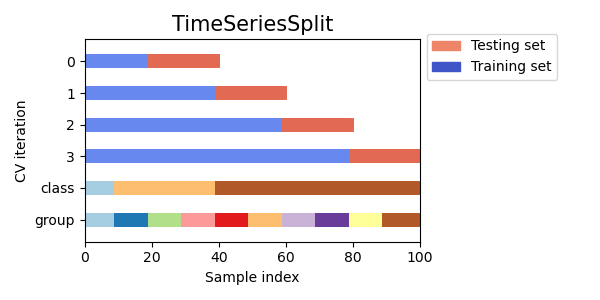

Example of 3-split time series cross-validation on a dataset with 6 samples:

In [132]:
from sklearn.model_selection import TimeSeriesSplit

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit(n_splits=3)
print(tscv)

for train, test in tscv.split(X):
    print("%s %s" % (train, test))

TimeSeriesSplit(max_train_size=None, n_splits=3)
[0 1 2] [3]
[0 1 2 3] [4]
[0 1 2 3 4] [5]


# Note on shuffling:-

1. If the data ordering is not arbitrary (e.g. samples with the same class label are contiguous), shuffling it first may be essential to get a meaningful cross- validation result. However, the opposite may be true if the samples are not independently and identically distributed. For example, if samples correspond to news articles, and are ordered by their time of publication, then shuffling the data will likely lead to a model that is overfit and an inflated validation score: it will be tested on samples that are artificially similar (close in time) to training samples.


2. Some cross validation iterators, such as KFold, have an inbuilt option to shuffle the data indices before splitting them


3. This consumes less memory than shuffling the data directly.


4. By default no shuffling occurs, including for the (stratified) K fold cross- validation performed by specifying cv=some_integer to cross_val_score, grid search, etc. Keep in mind that train_test_split still returns a random split.


5. The random_state parameter defaults to None, meaning that the shuffling will be different every time KFold(..., shuffle=True) is iterated. However, GridSearchCV will use the same shuffling for each set of parameters validated by a single call to its fit method.


6. To get identical results for each split, set random_state to an integer.

# Permutation test score

permutation_test_score offers another way to evaluate the performance of classifiers. It provides a permutation-based p-value, which represents how likely an observed performance of the classifier would be obtained by chance. The null hypothesis in this test is that the classifier fails to leverage any statistical dependency between the features and the labels to make correct predictions on left out data. permutation_test_score generates a null distribution by calculating n_permutations different permutations of the data. In each permutation the labels are randomly shuffled, thereby removing any dependency between the features and the labels. The p-value output is the fraction of permutations for which the average cross-validation score obtained by the model is better than the cross-validation score obtained by the model using the original data. For reliable results n_permutations should typically be larger than 100 and cv between 3-10 folds.

A low p-value provides evidence that the dataset contains real dependency between features and labels and the classifier was able to utilize this to obtain good results. A high p-value could be due to a lack of dependency between features and labels (there is no difference in feature values between the classes) or because the classifier was not able to use the dependency in the data. In the latter case, using a more appropriate classifier that is able to utilize the structure in the data, would result in a low p-value.

Cross-validation provides information about how well a classifier generalizes, specifically the range of expected errors of the classifier. However, a classifier trained on a high dimensional dataset with no structure may still perform better than expected on cross-validation, just by chance. This can typically happen with small datasets with less than a few hundred samples. permutation_test_score provides information on whether the classifier has found a real class structure and can help in evaluating the performance of the classifier.

It is important to note that this test has been shown to produce low p-values even if there is only weak structure in the data because in the corresponding permutated datasets there is absolutely no structure. This test is therefore only able to show when the model reliably outperforms random guessing.

Finally, permutation_test_score is computed using brute force and interally fits (n_permutations + 1) * n_cv models. It is therefore only tractable with small datasets for which fitting an individual model is very fast.